In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
import keras_tuner as kt

In [75]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [76]:
dataset = pd.read_csv('../../data/pollution.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0


In [77]:
print(dataset.columns)

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE',
       'NW', 'SE', 'cv'],
      dtype='object')


In [78]:
# specify the number of lag hours
n_hours = 24*3
K = 6

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [79]:
# Pre-processing
stages = dataset[['pollution']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (43800, 1)
stages_supervised.shape: (43723, 78)


In [80]:
stages_supervised

,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
date,,,,,,,,,,,,,,,,,,,,,
2010-01-05 00:00:00,129.0,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,...,31.0,33.0,29.0,31.0,30.0,34.0,27.0,25.0,28.0,28.0
2010-01-05 01:00:00,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,...,33.0,29.0,31.0,30.0,34.0,27.0,25.0,28.0,28.0,27.0
2010-01-05 02:00:00,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,...,29.0,31.0,30.0,34.0,27.0,25.0,28.0,28.0,27.0,27.0
2010-01-05 03:00:00,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,148.0,...,31.0,30.0,34.0,27.0,25.0,28.0,28.0,27.0,27.0,27.0
2010-01-05 04:00:00,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,148.0,164.0,...,30.0,34.0,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 14:00:00,32.0,33.0,45.0,42.0,41.0,110.0,175.0,293.0,324.0,341.0,...,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0
2014-12-31 15:00:00,33.0,45.0,42.0,41.0,110.0,175.0,293.0,324.0,341.0,362.0,...,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0
2014-12-31 16:00:00,45.0,42.0,41.0,110.0,175.0,293.0,324.0,341.0,362.0,372.0,...,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0


#### Prior unknown covariates (6)

In [81]:
# prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
# print("prior_unknown.shape:", prior_unknown.shape)

# prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, K)
# print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

In [82]:
# prior_unknown_supervised

#### Prior known covariates (9)

In [83]:
prior_known = dataset[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, K)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (43800, 10)
prior_known_supervised.shape: (43723, 780)


In [84]:
# prior_known_supervised

### N_out, N_in, K

In [85]:
past_cov = dataset[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]

past_cov_supervised = series_to_supervised(past_cov, n_hours, K)
print("past_cov_supervised.shape:", past_cov_supervised.shape)

past_cov_supervised.shape: (43723, 780)


In [86]:
# past_cov_supervised  # 6 + 9 = 15 features

In [87]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [88]:
# past_ws_supervised  # 4

In [89]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*past_cov.shape[1]:(i+1)*past_cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [90]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised, past_ws_supervised], axis=1)
past_cov_ws_supervised = past_cov_ws_supervised[columns]


In [91]:
# past_cov_ws_supervised

In [92]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, K*prior_known.shape[1]:]  # shift 2 days for prior known covariates
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-66),shift_prior_known_supervised_var2(t-66),shift_prior_known_supervised_var3(t-66),shift_prior_known_supervised_var4(t-66),shift_prior_known_supervised_var5(t-66),shift_prior_known_supervised_var6(t-66),shift_prior_known_supervised_var7(t-66),shift_prior_known_supervised_var8(t-66),shift_prior_known_supervised_var9(t-66),shift_prior_known_supervised_var10(t-66),...,shift_prior_known_supervised_var1(t+5),shift_prior_known_supervised_var2(t+5),shift_prior_known_supervised_var3(t+5),shift_prior_known_supervised_var4(t+5),shift_prior_known_supervised_var5(t+5),shift_prior_known_supervised_var6(t+5),shift_prior_known_supervised_var7(t+5),shift_prior_known_supervised_var8(t+5),shift_prior_known_supervised_var9(t+5),shift_prior_known_supervised_var10(t+5)
0,-7.0,-6.0,1023.0,8.93,4.0,0.0,0.0,0.0,1.0,0.0,...,-27.0,-16.0,1034.0,4.92,0.0,0.0,1.0,0.0,0.0,0.0
1,-7.0,-5.0,1024.0,10.72,0.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-16.0,1035.0,8.05,0.0,0.0,1.0,0.0,0.0,0.0
2,-8.0,-6.0,1024.0,12.51,0.0,0.0,0.0,0.0,1.0,0.0,...,-27.0,-16.0,1034.0,13.86,0.0,0.0,1.0,0.0,0.0,0.0
3,-7.0,-5.0,1025.0,14.30,0.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-16.0,1035.0,18.78,0.0,0.0,1.0,0.0,0.0,0.0
4,-7.0,-5.0,1026.0,17.43,1.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-15.0,1035.0,24.59,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43718,-13.0,3.0,1017.0,0.89,0.0,0.0,0.0,0.0,0.0,1.0,...,-23.0,-2.0,1034.0,231.97,0.0,0.0,0.0,1.0,0.0,0.0
43719,-13.0,1.0,1017.0,1.78,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,237.78,0.0,0.0,0.0,1.0,0.0,0.0
43720,-10.0,2.0,1017.0,2.67,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,242.70,0.0,0.0,0.0,1.0,0.0,0.0
43721,-10.0,-2.0,1017.0,3.12,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-4.0,1034.0,246.72,0.0,0.0,0.0,1.0,0.0,0.0


In [93]:
shift_prior_known_past_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], axis=1)


In [94]:
# shift_prior_known_past_cov_ws_supervised

In [95]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
0,30.0,34.0,27.0,25.0,28.0,28.0
1,34.0,27.0,25.0,28.0,28.0,27.0
2,27.0,25.0,28.0,28.0,27.0,27.0
3,25.0,28.0,28.0,27.0,27.0,27.0
4,28.0,28.0,27.0,27.0,27.0,29.0
...,...,...,...,...,...,...
43718,9.0,11.0,8.0,9.0,10.0,8.0
43719,11.0,8.0,9.0,10.0,8.0,10.0
43720,8.0,9.0,10.0,8.0,10.0,10.0
43721,9.0,10.0,8.0,10.0,10.0,8.0


### Concatenation

In [96]:
all_data = concat([shift_prior_known_past_cov_ws_supervised, future_ws_supervised], axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (43723, 1518)


### Train & Test set

In [97]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 34978


In [98]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

1512

### Normalization

In [99]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (34978, 1512) (34978, 6) (8745, 1512) (8745, 6)


In [100]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (34978, 72, 21) (34978, 6) (8745, 72, 21) (8745, 6)


### Model

In [101]:
# define model
model_cnn = keras.Sequential()
model_cnn.add(layers.Conv1D(filters=256, 
                            kernel_size=2, 
                            activation='relu', 
                            kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                            input_shape=(train_X.shape[1], train_X.shape[2])))
# model_cnn.add(layers.MaxPooling1D(pool_size=2, padding="valid"))

model_cnn.add(layers.Flatten())

# l1 and l2 becomes bigger --> smooth decrease --> more epoches
model_cnn.add(layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5)))
model_cnn.add(layers.Dense(train_y.shape[1]))
model_cnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 71, 256)           11008     
_________________________________________________________________
flatten_6 (Flatten)          (None, 18176)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               4653312   
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 1542      
Total params: 4,665,862
Trainable params: 4,665,862
Non-trainable params: 0
_________________________________________________________________


Epoch 1/8000

Epoch 00001: val_mae improved from inf to 0.07429, saving model to saved_model/cnn_shift_best_model_6h_cp1.h5
69/69 - 14s - loss: 0.3902 - mae: 0.0690 - val_loss: 0.3351 - val_mae: 0.0743
Epoch 2/8000

Epoch 00002: val_mae improved from 0.07429 to 0.06784, saving model to saved_model/cnn_shift_best_model_6h_cp1.h5
69/69 - 2s - loss: 0.2784 - mae: 0.0490 - val_loss: 0.2365 - val_mae: 0.0678
Epoch 3/8000

Epoch 00003: val_mae improved from 0.06784 to 0.06220, saving model to saved_model/cnn_shift_best_model_6h_cp1.h5
69/69 - 2s - loss: 0.1990 - mae: 0.0445 - val_loss: 0.1758 - val_mae: 0.0622
Epoch 4/8000

Epoch 00004: val_mae improved from 0.06220 to 0.05816, saving model to saved_model/cnn_shift_best_model_6h_cp1.h5
69/69 - 2s - loss: 0.1529 - mae: 0.0414 - val_loss: 0.1397 - val_mae: 0.0582
Epoch 5/8000

Epoch 00005: val_mae improved from 0.05816 to 0.05591, saving model to saved_model/cnn_shift_best_model_6h_cp1.h5
69/69 - 2s - loss: 0.1225 - mae: 0.0393 - val_loss: 0.1

Epoch 46/8000

Epoch 00046: val_mae did not improve from 0.03911
69/69 - 1s - loss: 0.0052 - mae: 0.0281 - val_loss: 0.0073 - val_mae: 0.0393
Epoch 47/8000

Epoch 00047: val_mae did not improve from 0.03911
69/69 - 1s - loss: 0.0050 - mae: 0.0277 - val_loss: 0.0072 - val_mae: 0.0392
Epoch 48/8000

Epoch 00048: val_mae did not improve from 0.03911
69/69 - 1s - loss: 0.0049 - mae: 0.0278 - val_loss: 0.0071 - val_mae: 0.0416
Epoch 49/8000

Epoch 00049: val_mae did not improve from 0.03911
69/69 - 1s - loss: 0.0049 - mae: 0.0287 - val_loss: 0.0071 - val_mae: 0.0392
Epoch 50/8000

Epoch 00050: val_mae did not improve from 0.03911
69/69 - 1s - loss: 0.0048 - mae: 0.0276 - val_loss: 0.0070 - val_mae: 0.0394
Epoch 51/8000

Epoch 00051: val_mae did not improve from 0.03911
69/69 - 1s - loss: 0.0047 - mae: 0.0278 - val_loss: 0.0068 - val_mae: 0.0394
Epoch 52/8000

Epoch 00052: val_mae improved from 0.03911 to 0.03876, saving model to saved_model/cnn_shift_best_model_6h_cp1.h5
69/69 - 2s - loss: 

Epoch 96/8000

Epoch 00096: val_mae did not improve from 0.03667
69/69 - 1s - loss: 0.0032 - mae: 0.0265 - val_loss: 0.0051 - val_mae: 0.0372
Epoch 97/8000

Epoch 00097: val_mae did not improve from 0.03667
69/69 - 1s - loss: 0.0032 - mae: 0.0262 - val_loss: 0.0052 - val_mae: 0.0383
Epoch 98/8000

Epoch 00098: val_mae did not improve from 0.03667
69/69 - 1s - loss: 0.0032 - mae: 0.0261 - val_loss: 0.0051 - val_mae: 0.0368
Epoch 99/8000

Epoch 00099: val_mae did not improve from 0.03667
69/69 - 1s - loss: 0.0032 - mae: 0.0261 - val_loss: 0.0052 - val_mae: 0.0370
Epoch 100/8000

Epoch 00100: val_mae did not improve from 0.03667
69/69 - 1s - loss: 0.0032 - mae: 0.0261 - val_loss: 0.0051 - val_mae: 0.0367
Epoch 101/8000

Epoch 00101: val_mae improved from 0.03667 to 0.03665, saving model to saved_model/cnn_shift_best_model_6h_cp1.h5
69/69 - 1s - loss: 0.0031 - mae: 0.0259 - val_loss: 0.0050 - val_mae: 0.0366
Epoch 102/8000

Epoch 00102: val_mae did not improve from 0.03665
69/69 - 1s - los


Epoch 00147: val_mae did not improve from 0.03542
69/69 - 1s - loss: 0.0028 - mae: 0.0259 - val_loss: 0.0046 - val_mae: 0.0355
Epoch 148/8000

Epoch 00148: val_mae did not improve from 0.03542
69/69 - 1s - loss: 0.0028 - mae: 0.0255 - val_loss: 0.0046 - val_mae: 0.0361
Epoch 149/8000

Epoch 00149: val_mae improved from 0.03542 to 0.03542, saving model to saved_model/cnn_shift_best_model_6h_cp1.h5
69/69 - 1s - loss: 0.0028 - mae: 0.0253 - val_loss: 0.0046 - val_mae: 0.0354
Epoch 150/8000

Epoch 00150: val_mae did not improve from 0.03542
69/69 - 1s - loss: 0.0028 - mae: 0.0253 - val_loss: 0.0046 - val_mae: 0.0357
Epoch 151/8000

Epoch 00151: val_mae improved from 0.03542 to 0.03530, saving model to saved_model/cnn_shift_best_model_6h_cp1.h5
69/69 - 1s - loss: 0.0028 - mae: 0.0253 - val_loss: 0.0046 - val_mae: 0.0353
Epoch 152/8000

Epoch 00152: val_mae did not improve from 0.03530
69/69 - 1s - loss: 0.0028 - mae: 0.0253 - val_loss: 0.0046 - val_mae: 0.0354
Epoch 153/8000

Epoch 00153: 

Epoch 201/8000

Epoch 00201: val_mae did not improve from 0.03492
69/69 - 1s - loss: 0.0026 - mae: 0.0249 - val_loss: 0.0044 - val_mae: 0.0350
Epoch 202/8000

Epoch 00202: val_mae did not improve from 0.03492
69/69 - 1s - loss: 0.0026 - mae: 0.0249 - val_loss: 0.0044 - val_mae: 0.0355
Epoch 203/8000

Epoch 00203: val_mae did not improve from 0.03492
69/69 - 1s - loss: 0.0026 - mae: 0.0250 - val_loss: 0.0045 - val_mae: 0.0369
Epoch 204/8000

Epoch 00204: val_mae did not improve from 0.03492
69/69 - 1s - loss: 0.0026 - mae: 0.0252 - val_loss: 0.0044 - val_mae: 0.0358
Epoch 205/8000

Epoch 00205: val_mae improved from 0.03492 to 0.03473, saving model to saved_model/cnn_shift_best_model_6h_cp1.h5
69/69 - 1s - loss: 0.0026 - mae: 0.0250 - val_loss: 0.0044 - val_mae: 0.0347
Epoch 206/8000

Epoch 00206: val_mae did not improve from 0.03473
69/69 - 1s - loss: 0.0026 - mae: 0.0249 - val_loss: 0.0045 - val_mae: 0.0359
Epoch 207/8000

Epoch 00207: val_mae did not improve from 0.03473
69/69 - 1s -


Epoch 00256: val_mae did not improve from 0.03445
69/69 - 1s - loss: 0.0025 - mae: 0.0248 - val_loss: 0.0045 - val_mae: 0.0376
Epoch 257/8000

Epoch 00257: val_mae did not improve from 0.03445
69/69 - 1s - loss: 0.0025 - mae: 0.0246 - val_loss: 0.0043 - val_mae: 0.0347
Epoch 258/8000

Epoch 00258: val_mae did not improve from 0.03445
69/69 - 1s - loss: 0.0025 - mae: 0.0246 - val_loss: 0.0043 - val_mae: 0.0347
Epoch 259/8000

Epoch 00259: val_mae did not improve from 0.03445
69/69 - 1s - loss: 0.0025 - mae: 0.0246 - val_loss: 0.0043 - val_mae: 0.0353
Epoch 260/8000

Epoch 00260: val_mae did not improve from 0.03445
69/69 - 1s - loss: 0.0025 - mae: 0.0248 - val_loss: 0.0043 - val_mae: 0.0355
Epoch 261/8000

Epoch 00261: val_mae did not improve from 0.03445
69/69 - 1s - loss: 0.0025 - mae: 0.0247 - val_loss: 0.0043 - val_mae: 0.0347
Epoch 262/8000

Epoch 00262: val_mae did not improve from 0.03445
69/69 - 1s - loss: 0.0025 - mae: 0.0245 - val_loss: 0.0043 - val_mae: 0.0347
Epoch 263/8000

Epoch 311/8000

Epoch 00311: val_mae did not improve from 0.03413
69/69 - 1s - loss: 0.0025 - mae: 0.0244 - val_loss: 0.0043 - val_mae: 0.0351
Epoch 312/8000

Epoch 00312: val_mae did not improve from 0.03413
69/69 - 1s - loss: 0.0025 - mae: 0.0244 - val_loss: 0.0042 - val_mae: 0.0349
Epoch 313/8000

Epoch 00313: val_mae did not improve from 0.03413
69/69 - 1s - loss: 0.0025 - mae: 0.0247 - val_loss: 0.0043 - val_mae: 0.0358
Epoch 314/8000

Epoch 00314: val_mae did not improve from 0.03413
69/69 - 1s - loss: 0.0025 - mae: 0.0247 - val_loss: 0.0042 - val_mae: 0.0344
Epoch 315/8000

Epoch 00315: val_mae did not improve from 0.03413
69/69 - 1s - loss: 0.0025 - mae: 0.0243 - val_loss: 0.0043 - val_mae: 0.0357
Epoch 316/8000

Epoch 00316: val_mae did not improve from 0.03413
69/69 - 1s - loss: 0.0025 - mae: 0.0242 - val_loss: 0.0042 - val_mae: 0.0342
Epoch 317/8000

Epoch 00317: val_mae did not improve from 0.03413
69/69 - 1s - loss: 0.0025 - mae: 0.0242 - val_loss: 0.0042 - val_mae: 0.0349

Epoch 368/8000

Epoch 00368: val_mae did not improve from 0.03403
69/69 - 1s - loss: 0.0024 - mae: 0.0242 - val_loss: 0.0041 - val_mae: 0.0343
Epoch 369/8000

Epoch 00369: val_mae did not improve from 0.03403
69/69 - 1s - loss: 0.0024 - mae: 0.0239 - val_loss: 0.0041 - val_mae: 0.0342
Epoch 370/8000

Epoch 00370: val_mae did not improve from 0.03403
69/69 - 1s - loss: 0.0024 - mae: 0.0243 - val_loss: 0.0042 - val_mae: 0.0344
Epoch 371/8000

Epoch 00371: val_mae did not improve from 0.03403
69/69 - 1s - loss: 0.0024 - mae: 0.0240 - val_loss: 0.0042 - val_mae: 0.0351
Epoch 372/8000

Epoch 00372: val_mae did not improve from 0.03403
69/69 - 1s - loss: 0.0024 - mae: 0.0240 - val_loss: 0.0041 - val_mae: 0.0341
Epoch 373/8000

Epoch 00373: val_mae did not improve from 0.03403
69/69 - 1s - loss: 0.0024 - mae: 0.0243 - val_loss: 0.0041 - val_mae: 0.0344
Epoch 374/8000

Epoch 00374: val_mae did not improve from 0.03403
69/69 - 1s - loss: 0.0024 - mae: 0.0241 - val_loss: 0.0041 - val_mae: 0.0342

Epoch 425/8000

Epoch 00425: val_mae did not improve from 0.03392
69/69 - 1s - loss: 0.0024 - mae: 0.0240 - val_loss: 0.0041 - val_mae: 0.0340
Epoch 426/8000

Epoch 00426: val_mae did not improve from 0.03392
69/69 - 1s - loss: 0.0024 - mae: 0.0240 - val_loss: 0.0041 - val_mae: 0.0343
Epoch 427/8000

Epoch 00427: val_mae did not improve from 0.03392
69/69 - 1s - loss: 0.0024 - mae: 0.0237 - val_loss: 0.0041 - val_mae: 0.0340
Epoch 428/8000

Epoch 00428: val_mae did not improve from 0.03392
69/69 - 1s - loss: 0.0024 - mae: 0.0238 - val_loss: 0.0041 - val_mae: 0.0342
Epoch 429/8000

Epoch 00429: val_mae did not improve from 0.03392
69/69 - 1s - loss: 0.0024 - mae: 0.0239 - val_loss: 0.0041 - val_mae: 0.0347
Epoch 430/8000

Epoch 00430: val_mae did not improve from 0.03392
69/69 - 1s - loss: 0.0024 - mae: 0.0241 - val_loss: 0.0042 - val_mae: 0.0350
Epoch 431/8000

Epoch 00431: val_mae did not improve from 0.03392
69/69 - 1s - loss: 0.0024 - mae: 0.0245 - val_loss: 0.0041 - val_mae: 0.0343

Epoch 481/8000

Epoch 00481: val_mae did not improve from 0.03382
69/69 - 1s - loss: 0.0023 - mae: 0.0238 - val_loss: 0.0041 - val_mae: 0.0339
Epoch 482/8000

Epoch 00482: val_mae improved from 0.03382 to 0.03364, saving model to saved_model/cnn_shift_best_model_6h_cp1.h5
69/69 - 1s - loss: 0.0023 - mae: 0.0236 - val_loss: 0.0040 - val_mae: 0.0336
Epoch 483/8000

Epoch 00483: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0238 - val_loss: 0.0041 - val_mae: 0.0342
Epoch 484/8000

Epoch 00484: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0239 - val_loss: 0.0041 - val_mae: 0.0347
Epoch 485/8000

Epoch 00485: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0236 - val_loss: 0.0041 - val_mae: 0.0347
Epoch 486/8000

Epoch 00486: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0237 - val_loss: 0.0040 - val_mae: 0.0337
Epoch 487/8000

Epoch 00487: val_mae did not improve from 0.03364
69/69 - 1s -

Epoch 538/8000

Epoch 00538: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0235 - val_loss: 0.0040 - val_mae: 0.0338
Epoch 539/8000

Epoch 00539: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0236 - val_loss: 0.0040 - val_mae: 0.0337
Epoch 540/8000

Epoch 00540: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0236 - val_loss: 0.0041 - val_mae: 0.0341
Epoch 541/8000

Epoch 00541: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0234 - val_loss: 0.0042 - val_mae: 0.0353
Epoch 542/8000

Epoch 00542: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0235 - val_loss: 0.0040 - val_mae: 0.0340
Epoch 543/8000

Epoch 00543: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0236 - val_loss: 0.0041 - val_mae: 0.0341
Epoch 544/8000

Epoch 00544: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0236 - val_loss: 0.0041 - val_mae: 0.0344

Epoch 596/8000

Epoch 00596: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0235 - val_loss: 0.0041 - val_mae: 0.0339
Epoch 597/8000

Epoch 00597: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0234 - val_loss: 0.0041 - val_mae: 0.0339
Epoch 598/8000

Epoch 00598: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0236 - val_loss: 0.0040 - val_mae: 0.0337
Epoch 599/8000

Epoch 00599: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0235 - val_loss: 0.0042 - val_mae: 0.0352
Epoch 600/8000

Epoch 00600: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0236 - val_loss: 0.0041 - val_mae: 0.0340
Epoch 601/8000

Epoch 00601: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0234 - val_loss: 0.0042 - val_mae: 0.0355
Epoch 602/8000

Epoch 00602: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0235 - val_loss: 0.0042 - val_mae: 0.0354

Epoch 653/8000

Epoch 00653: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0233 - val_loss: 0.0041 - val_mae: 0.0351
Epoch 654/8000

Epoch 00654: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0233 - val_loss: 0.0043 - val_mae: 0.0364
Epoch 655/8000

Epoch 00655: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0235 - val_loss: 0.0041 - val_mae: 0.0342
Epoch 656/8000

Epoch 00656: val_mae did not improve from 0.03364
69/69 - 1s - loss: 0.0023 - mae: 0.0232 - val_loss: 0.0041 - val_mae: 0.0340
Epoch 657/8000

Epoch 00657: val_mae improved from 0.03364 to 0.03353, saving model to saved_model/cnn_shift_best_model_6h_cp1.h5
69/69 - 1s - loss: 0.0023 - mae: 0.0232 - val_loss: 0.0040 - val_mae: 0.0335
Epoch 658/8000

Epoch 00658: val_mae did not improve from 0.03353
69/69 - 1s - loss: 0.0023 - mae: 0.0232 - val_loss: 0.0040 - val_mae: 0.0336
Epoch 659/8000

Epoch 00659: val_mae did not improve from 0.03353
69/69 - 1s -

Epoch 710/8000

Epoch 00710: val_mae did not improve from 0.03353
69/69 - 1s - loss: 0.0023 - mae: 0.0234 - val_loss: 0.0041 - val_mae: 0.0341
Epoch 711/8000

Epoch 00711: val_mae did not improve from 0.03353
69/69 - 1s - loss: 0.0023 - mae: 0.0233 - val_loss: 0.0042 - val_mae: 0.0351
Epoch 712/8000

Epoch 00712: val_mae did not improve from 0.03353
69/69 - 1s - loss: 0.0023 - mae: 0.0233 - val_loss: 0.0041 - val_mae: 0.0340
Epoch 713/8000

Epoch 00713: val_mae did not improve from 0.03353
69/69 - 1s - loss: 0.0022 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0348
Epoch 714/8000

Epoch 00714: val_mae did not improve from 0.03353
69/69 - 1s - loss: 0.0022 - mae: 0.0233 - val_loss: 0.0040 - val_mae: 0.0336
Epoch 715/8000

Epoch 00715: val_mae did not improve from 0.03353
69/69 - 1s - loss: 0.0023 - mae: 0.0233 - val_loss: 0.0041 - val_mae: 0.0344
Epoch 716/8000

Epoch 00716: val_mae did not improve from 0.03353
69/69 - 1s - loss: 0.0022 - mae: 0.0232 - val_loss: 0.0041 - val_mae: 0.0345

Epoch 767/8000

Epoch 00767: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0231 - val_loss: 0.0040 - val_mae: 0.0340
Epoch 768/8000

Epoch 00768: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0231 - val_loss: 0.0042 - val_mae: 0.0353
Epoch 769/8000

Epoch 00769: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0232 - val_loss: 0.0041 - val_mae: 0.0342
Epoch 770/8000

Epoch 00770: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0232 - val_loss: 0.0042 - val_mae: 0.0354
Epoch 771/8000

Epoch 00771: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0340
Epoch 772/8000

Epoch 00772: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0231 - val_loss: 0.0040 - val_mae: 0.0338
Epoch 773/8000

Epoch 00773: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0023 - mae: 0.0236 - val_loss: 0.0041 - val_mae: 0.0343

Epoch 825/8000

Epoch 00825: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0346
Epoch 826/8000

Epoch 00826: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0234 - val_loss: 0.0040 - val_mae: 0.0338
Epoch 827/8000

Epoch 00827: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0230 - val_loss: 0.0041 - val_mae: 0.0340
Epoch 828/8000

Epoch 00828: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0231 - val_loss: 0.0040 - val_mae: 0.0339
Epoch 829/8000

Epoch 00829: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0345
Epoch 830/8000

Epoch 00830: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0232 - val_loss: 0.0041 - val_mae: 0.0341
Epoch 831/8000

Epoch 00831: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0230 - val_loss: 0.0042 - val_mae: 0.0350

Epoch 883/8000

Epoch 00883: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0232 - val_loss: 0.0040 - val_mae: 0.0339
Epoch 884/8000

Epoch 00884: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0230 - val_loss: 0.0042 - val_mae: 0.0351
Epoch 885/8000

Epoch 00885: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0230 - val_loss: 0.0042 - val_mae: 0.0350
Epoch 886/8000

Epoch 00886: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0230 - val_loss: 0.0040 - val_mae: 0.0340
Epoch 887/8000

Epoch 00887: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0232 - val_loss: 0.0041 - val_mae: 0.0341
Epoch 888/8000

Epoch 00888: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0341
Epoch 889/8000

Epoch 00889: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0230 - val_loss: 0.0041 - val_mae: 0.0349

Epoch 941/8000

Epoch 00941: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0347
Epoch 942/8000

Epoch 00942: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0230 - val_loss: 0.0041 - val_mae: 0.0347
Epoch 943/8000

Epoch 00943: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0345
Epoch 944/8000

Epoch 00944: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0229 - val_loss: 0.0040 - val_mae: 0.0340
Epoch 945/8000

Epoch 00945: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0230 - val_loss: 0.0041 - val_mae: 0.0349
Epoch 946/8000

Epoch 00946: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0231 - val_loss: 0.0042 - val_mae: 0.0353
Epoch 947/8000

Epoch 00947: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0231 - val_loss: 0.0040 - val_mae: 0.0341

Epoch 999/8000

Epoch 00999: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0228 - val_loss: 0.0040 - val_mae: 0.0339
Epoch 1000/8000

Epoch 01000: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0231 - val_loss: 0.0040 - val_mae: 0.0339
Epoch 1001/8000

Epoch 01001: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0229 - val_loss: 0.0041 - val_mae: 0.0352
Epoch 1002/8000

Epoch 01002: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0231 - val_loss: 0.0041 - val_mae: 0.0348
Epoch 1003/8000

Epoch 01003: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0229 - val_loss: 0.0041 - val_mae: 0.0349
Epoch 1004/8000

Epoch 01004: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0231 - val_loss: 0.0040 - val_mae: 0.0339
Epoch 1005/8000

Epoch 01005: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0229 - val_loss: 0.0040 - val_mae: 

Epoch 1056/8000

Epoch 01056: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0229 - val_loss: 0.0041 - val_mae: 0.0341
Epoch 1057/8000

Epoch 01057: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0229 - val_loss: 0.0041 - val_mae: 0.0347
Epoch 1058/8000

Epoch 01058: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0233 - val_loss: 0.0041 - val_mae: 0.0343
Epoch 1059/8000

Epoch 01059: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0230 - val_loss: 0.0042 - val_mae: 0.0352
Epoch 1060/8000

Epoch 01060: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0229 - val_loss: 0.0040 - val_mae: 0.0341
Epoch 1061/8000

Epoch 01061: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0228 - val_loss: 0.0041 - val_mae: 0.0347
Epoch 1062/8000

Epoch 01062: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0228 - val_loss: 0.0041 - val_mae:

Epoch 1113/8000

Epoch 01113: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0229 - val_loss: 0.0041 - val_mae: 0.0340
Epoch 1114/8000

Epoch 01114: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0229 - val_loss: 0.0040 - val_mae: 0.0341
Epoch 1115/8000

Epoch 01115: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0228 - val_loss: 0.0041 - val_mae: 0.0344
Epoch 1116/8000

Epoch 01116: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0228 - val_loss: 0.0040 - val_mae: 0.0340
Epoch 1117/8000

Epoch 01117: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0228 - val_loss: 0.0040 - val_mae: 0.0339
Epoch 1118/8000

Epoch 01118: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0228 - val_loss: 0.0041 - val_mae: 0.0345
Epoch 1119/8000

Epoch 01119: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0229 - val_loss: 0.0040 - val_mae:

Epoch 1170/8000

Epoch 01170: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0228 - val_loss: 0.0041 - val_mae: 0.0350
Epoch 1171/8000

Epoch 01171: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0229 - val_loss: 0.0042 - val_mae: 0.0356
Epoch 1172/8000

Epoch 01172: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0229 - val_loss: 0.0043 - val_mae: 0.0365
Epoch 1173/8000

Epoch 01173: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0228 - val_loss: 0.0043 - val_mae: 0.0361
Epoch 1174/8000

Epoch 01174: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0041 - val_mae: 0.0343
Epoch 1175/8000

Epoch 01175: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0229 - val_loss: 0.0041 - val_mae: 0.0346
Epoch 1176/8000

Epoch 01176: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0228 - val_loss: 0.0040 - val_mae:

Epoch 1227/8000

Epoch 01227: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0040 - val_mae: 0.0343
Epoch 1228/8000

Epoch 01228: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0228 - val_loss: 0.0041 - val_mae: 0.0346
Epoch 1229/8000

Epoch 01229: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0228 - val_loss: 0.0040 - val_mae: 0.0341
Epoch 1230/8000

Epoch 01230: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0040 - val_mae: 0.0339
Epoch 1231/8000

Epoch 01231: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0228 - val_loss: 0.0041 - val_mae: 0.0347
Epoch 1232/8000

Epoch 01232: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0041 - val_mae: 0.0349
Epoch 1233/8000

Epoch 01233: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0229 - val_loss: 0.0041 - val_mae:

Epoch 1284/8000

Epoch 01284: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0228 - val_loss: 0.0040 - val_mae: 0.0340
Epoch 1285/8000

Epoch 01285: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0228 - val_loss: 0.0042 - val_mae: 0.0350
Epoch 1286/8000

Epoch 01286: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0228 - val_loss: 0.0041 - val_mae: 0.0343
Epoch 1287/8000

Epoch 01287: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0230 - val_loss: 0.0040 - val_mae: 0.0341
Epoch 1288/8000

Epoch 01288: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0229 - val_loss: 0.0040 - val_mae: 0.0342
Epoch 1289/8000

Epoch 01289: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0042 - val_mae: 0.0355
Epoch 1290/8000

Epoch 01290: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0022 - mae: 0.0230 - val_loss: 0.0041 - val_mae:

Epoch 1341/8000

Epoch 01341: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0229 - val_loss: 0.0040 - val_mae: 0.0345
Epoch 1342/8000

Epoch 01342: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0040 - val_mae: 0.0341
Epoch 1343/8000

Epoch 01343: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0040 - val_mae: 0.0340
Epoch 1344/8000

Epoch 01344: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0229 - val_loss: 0.0041 - val_mae: 0.0349
Epoch 1345/8000

Epoch 01345: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0229 - val_loss: 0.0043 - val_mae: 0.0356
Epoch 1346/8000

Epoch 01346: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0229 - val_loss: 0.0040 - val_mae: 0.0343
Epoch 1347/8000

Epoch 01347: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0041 - val_mae:

Epoch 1398/8000

Epoch 01398: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0041 - val_mae: 0.0350
Epoch 1399/8000

Epoch 01399: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0226 - val_loss: 0.0041 - val_mae: 0.0346
Epoch 1400/8000

Epoch 01400: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0345
Epoch 1401/8000

Epoch 01401: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0040 - val_mae: 0.0344
Epoch 1402/8000

Epoch 01402: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0230 - val_loss: 0.0042 - val_mae: 0.0364
Epoch 1403/8000

Epoch 01403: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0041 - val_mae: 0.0345
Epoch 1404/8000

Epoch 01404: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0226 - val_loss: 0.0043 - val_mae:

Epoch 1455/8000

Epoch 01455: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0226 - val_loss: 0.0041 - val_mae: 0.0344
Epoch 1456/8000

Epoch 01456: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0040 - val_mae: 0.0344
Epoch 1457/8000

Epoch 01457: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0345
Epoch 1458/8000

Epoch 01458: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0226 - val_loss: 0.0041 - val_mae: 0.0343
Epoch 1459/8000

Epoch 01459: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0228 - val_loss: 0.0042 - val_mae: 0.0358
Epoch 1460/8000

Epoch 01460: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0042 - val_mae: 0.0349
Epoch 1461/8000

Epoch 01461: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0226 - val_loss: 0.0041 - val_mae:

Epoch 1512/8000

Epoch 01512: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0226 - val_loss: 0.0041 - val_mae: 0.0344
Epoch 1513/8000

Epoch 01513: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0040 - val_mae: 0.0343
Epoch 1514/8000

Epoch 01514: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0040 - val_mae: 0.0342
Epoch 1515/8000

Epoch 01515: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0042 - val_mae: 0.0353
Epoch 1516/8000

Epoch 01516: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0230 - val_loss: 0.0040 - val_mae: 0.0343
Epoch 1517/8000

Epoch 01517: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0040 - val_mae: 0.0344
Epoch 1518/8000

Epoch 01518: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0040 - val_mae:

Epoch 1569/8000

Epoch 01569: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0229 - val_loss: 0.0040 - val_mae: 0.0343
Epoch 1570/8000

Epoch 01570: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0042 - val_mae: 0.0360
Epoch 1571/8000

Epoch 01571: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0226 - val_loss: 0.0041 - val_mae: 0.0345
Epoch 1572/8000

Epoch 01572: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0228 - val_loss: 0.0041 - val_mae: 0.0347
Epoch 1573/8000

Epoch 01573: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0226 - val_loss: 0.0040 - val_mae: 0.0342
Epoch 1574/8000

Epoch 01574: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0042 - val_mae: 0.0359
Epoch 1575/8000

Epoch 01575: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0041 - val_mae:

Epoch 1626/8000

Epoch 01626: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0226 - val_loss: 0.0041 - val_mae: 0.0352
Epoch 1627/8000

Epoch 01627: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0226 - val_loss: 0.0041 - val_mae: 0.0344
Epoch 1628/8000

Epoch 01628: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0228 - val_loss: 0.0040 - val_mae: 0.0341
Epoch 1629/8000

Epoch 01629: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0346
Epoch 1630/8000

Epoch 01630: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0040 - val_mae: 0.0345
Epoch 1631/8000

Epoch 01631: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0040 - val_mae: 0.0342
Epoch 1632/8000

Epoch 01632: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0226 - val_loss: 0.0040 - val_mae:

Epoch 1683/8000

Epoch 01683: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0352
Epoch 1684/8000

Epoch 01684: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0041 - val_mae: 0.0350
Epoch 1685/8000

Epoch 01685: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0224 - val_loss: 0.0042 - val_mae: 0.0353
Epoch 1686/8000

Epoch 01686: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0224 - val_loss: 0.0042 - val_mae: 0.0351
Epoch 1687/8000

Epoch 01687: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0226 - val_loss: 0.0042 - val_mae: 0.0350
Epoch 1688/8000

Epoch 01688: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0348
Epoch 1689/8000

Epoch 01689: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae:

Epoch 1740/8000

Epoch 01740: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0345
Epoch 1741/8000

Epoch 01741: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0224 - val_loss: 0.0040 - val_mae: 0.0345
Epoch 1742/8000

Epoch 01742: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0040 - val_mae: 0.0342
Epoch 1743/8000

Epoch 01743: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0350
Epoch 1744/8000

Epoch 01744: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0040 - val_mae: 0.0344
Epoch 1745/8000

Epoch 01745: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0345
Epoch 1746/8000

Epoch 01746: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0224 - val_loss: 0.0041 - val_mae:

Epoch 1797/8000

Epoch 01797: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0344
Epoch 1798/8000

Epoch 01798: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0226 - val_loss: 0.0043 - val_mae: 0.0365
Epoch 1799/8000

Epoch 01799: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0224 - val_loss: 0.0041 - val_mae: 0.0347
Epoch 1800/8000

Epoch 01800: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0348
Epoch 1801/8000

Epoch 01801: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0226 - val_loss: 0.0041 - val_mae: 0.0354
Epoch 1802/8000

Epoch 01802: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0042 - val_mae: 0.0361
Epoch 1803/8000

Epoch 01803: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae:

Epoch 1854/8000

Epoch 01854: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0348
Epoch 1855/8000

Epoch 01855: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0344
Epoch 1856/8000

Epoch 01856: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0224 - val_loss: 0.0042 - val_mae: 0.0352
Epoch 1857/8000

Epoch 01857: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0040 - val_mae: 0.0345
Epoch 1858/8000

Epoch 01858: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0042 - val_mae: 0.0355
Epoch 1859/8000

Epoch 01859: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0346
Epoch 1860/8000

Epoch 01860: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0224 - val_loss: 0.0041 - val_mae:

Epoch 1911/8000

Epoch 01911: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0352
Epoch 1912/8000

Epoch 01912: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0223 - val_loss: 0.0040 - val_mae: 0.0341
Epoch 1913/8000

Epoch 01913: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0224 - val_loss: 0.0041 - val_mae: 0.0351
Epoch 1914/8000

Epoch 01914: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0224 - val_loss: 0.0040 - val_mae: 0.0345
Epoch 1915/8000

Epoch 01915: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0349
Epoch 1916/8000

Epoch 01916: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0224 - val_loss: 0.0041 - val_mae: 0.0349
Epoch 1917/8000

Epoch 01917: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae:

Epoch 1968/8000

Epoch 01968: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0044 - val_mae: 0.0371
Epoch 1969/8000

Epoch 01969: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0347
Epoch 1970/8000

Epoch 01970: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0224 - val_loss: 0.0040 - val_mae: 0.0344
Epoch 1971/8000

Epoch 01971: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0041 - val_mae: 0.0348
Epoch 1972/8000

Epoch 01972: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0040 - val_mae: 0.0342
Epoch 1973/8000

Epoch 01973: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0225 - val_loss: 0.0040 - val_mae: 0.0351
Epoch 1974/8000

Epoch 01974: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0224 - val_loss: 0.0040 - val_mae:

Epoch 2025/8000

Epoch 02025: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0224 - val_loss: 0.0040 - val_mae: 0.0343
Epoch 2026/8000

Epoch 02026: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0226 - val_loss: 0.0040 - val_mae: 0.0344
Epoch 2027/8000

Epoch 02027: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0041 - val_mae: 0.0354
Epoch 2028/8000

Epoch 02028: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0224 - val_loss: 0.0042 - val_mae: 0.0358
Epoch 2029/8000

Epoch 02029: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0224 - val_loss: 0.0042 - val_mae: 0.0352
Epoch 2030/8000

Epoch 02030: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0224 - val_loss: 0.0040 - val_mae: 0.0343
Epoch 2031/8000

Epoch 02031: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0224 - val_loss: 0.0041 - val_mae:

Epoch 2082/8000

Epoch 02082: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0041 - val_mae: 0.0348
Epoch 2083/8000

Epoch 02083: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0040 - val_mae: 0.0346
Epoch 2084/8000

Epoch 02084: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0043 - val_mae: 0.0363
Epoch 2085/8000

Epoch 02085: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0224 - val_loss: 0.0040 - val_mae: 0.0345
Epoch 2086/8000

Epoch 02086: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0224 - val_loss: 0.0041 - val_mae: 0.0345
Epoch 2087/8000

Epoch 02087: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0041 - val_mae: 0.0351
Epoch 2088/8000

Epoch 02088: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0043 - val_mae:

Epoch 2139/8000

Epoch 02139: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0349
Epoch 2140/8000

Epoch 02140: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0042 - val_mae: 0.0356
Epoch 2141/8000

Epoch 02141: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0224 - val_loss: 0.0042 - val_mae: 0.0352
Epoch 2142/8000

Epoch 02142: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0224 - val_loss: 0.0041 - val_mae: 0.0347
Epoch 2143/8000

Epoch 02143: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0043 - val_mae: 0.0362
Epoch 2144/8000

Epoch 02144: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0224 - val_loss: 0.0042 - val_mae: 0.0354
Epoch 2145/8000

Epoch 02145: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0224 - val_loss: 0.0041 - val_mae:

Epoch 2196/8000

Epoch 02196: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0043 - val_mae: 0.0363
Epoch 2197/8000

Epoch 02197: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0041 - val_mae: 0.0349
Epoch 2198/8000

Epoch 02198: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0224 - val_loss: 0.0042 - val_mae: 0.0354
Epoch 2199/8000

Epoch 02199: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0041 - val_mae: 0.0352
Epoch 2200/8000

Epoch 02200: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0042 - val_mae: 0.0350
Epoch 2201/8000

Epoch 02201: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0041 - val_mae: 0.0346
Epoch 2202/8000

Epoch 02202: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0041 - val_mae:

Epoch 2253/8000

Epoch 02253: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0042 - val_mae: 0.0358
Epoch 2254/8000

Epoch 02254: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0041 - val_mae: 0.0346
Epoch 2255/8000

Epoch 02255: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0040 - val_mae: 0.0345
Epoch 2256/8000

Epoch 02256: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0041 - val_mae: 0.0351
Epoch 2257/8000

Epoch 02257: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0042 - val_mae: 0.0351
Epoch 2258/8000

Epoch 02258: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0043 - val_mae: 0.0359
Epoch 2259/8000

Epoch 02259: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0224 - val_loss: 0.0041 - val_mae:

Epoch 2310/8000

Epoch 02310: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0225 - val_loss: 0.0041 - val_mae: 0.0345
Epoch 2311/8000

Epoch 02311: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0226 - val_loss: 0.0041 - val_mae: 0.0346
Epoch 2312/8000

Epoch 02312: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0042 - val_mae: 0.0352
Epoch 2313/8000

Epoch 02313: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0041 - val_mae: 0.0352
Epoch 2314/8000

Epoch 02314: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0041 - val_mae: 0.0348
Epoch 2315/8000

Epoch 02315: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0041 - val_mae: 0.0348
Epoch 2316/8000

Epoch 02316: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0042 - val_mae:

Epoch 2367/8000

Epoch 02367: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0225 - val_loss: 0.0042 - val_mae: 0.0358
Epoch 2368/8000

Epoch 02368: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0041 - val_mae: 0.0346
Epoch 2369/8000

Epoch 02369: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0042 - val_mae: 0.0355
Epoch 2370/8000

Epoch 02370: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0042 - val_mae: 0.0356
Epoch 2371/8000

Epoch 02371: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0041 - val_mae: 0.0352
Epoch 2372/8000

Epoch 02372: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0041 - val_mae: 0.0349
Epoch 2373/8000

Epoch 02373: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0041 - val_mae:

Epoch 2424/8000

Epoch 02424: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0041 - val_mae: 0.0348
Epoch 2425/8000

Epoch 02425: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0040 - val_mae: 0.0344
Epoch 2426/8000

Epoch 02426: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0228 - val_loss: 0.0042 - val_mae: 0.0351
Epoch 2427/8000

Epoch 02427: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0041 - val_mae: 0.0347
Epoch 2428/8000

Epoch 02428: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0041 - val_mae: 0.0347
Epoch 2429/8000

Epoch 02429: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0041 - val_mae: 0.0346
Epoch 2430/8000

Epoch 02430: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0042 - val_mae:

Epoch 2481/8000

Epoch 02481: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0042 - val_mae: 0.0353
Epoch 2482/8000

Epoch 02482: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0041 - val_mae: 0.0349
Epoch 2483/8000

Epoch 02483: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0044 - val_mae: 0.0366
Epoch 2484/8000

Epoch 02484: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0040 - val_mae: 0.0344
Epoch 2485/8000

Epoch 02485: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0041 - val_mae: 0.0347
Epoch 2486/8000

Epoch 02486: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0042 - val_mae: 0.0352
Epoch 2487/8000

Epoch 02487: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0222 - val_loss: 0.0040 - val_mae:

Epoch 2538/8000

Epoch 02538: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0226 - val_loss: 0.0040 - val_mae: 0.0343
Epoch 2539/8000

Epoch 02539: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0043 - val_mae: 0.0369
Epoch 2540/8000

Epoch 02540: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0224 - val_loss: 0.0041 - val_mae: 0.0345
Epoch 2541/8000

Epoch 02541: val_mae did not improve from 0.03351
69/69 - 1s - loss: 0.0020 - mae: 0.0223 - val_loss: 0.0043 - val_mae: 0.0360
Epoch 02541: early stopping


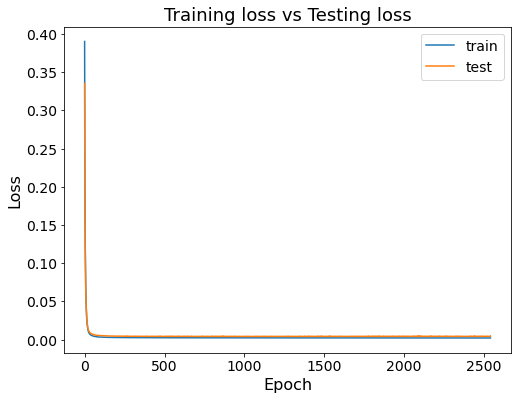

In [102]:
lr = 0.00001
EPOCHS = 8000 

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


model_cnn.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/cnn_shift_best_model_6h_cp1.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = model_cnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [103]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/cnn_shift_best_model_6h_cp1.h5')

In [104]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

error = inv_yhat - inv_y
print(error.shape)

inv_y.shape, inv_yhat.shape (8745, 6) (8745, 6)
(8745, 6)


In [105]:
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 22.488
RMSE = 38.188
